## Business understanding

### What decisions need to be made?
The decision to be made is which city in Wyoming should be chosen for the next Pawdacity store.
The criteria are:
- The new store must be located in a city without a current store
- Total sales for the competition should be less than \$500,000
- The new store must be located in a city with a population less then 4000 based on the 2014 census estimate
- Predicted yearly sales must be over \$200,000
- The city chosen should have the hightest predicted sales within the criteria

### What data is needed to make these decisions?
- Demographic data including 2010 and 2014 census data
- Pawdacity sales data for each store in Wyoming
- Competition sales data for each store in Wyoming

### Libraries

In [1]:
library( tidyverse )
library( broom )
library( PerformanceAnalytics )

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 2.2.1     ✔ purrr   0.2.4
✔ tibble  1.3.4     ✔ dplyr   0.7.4
✔ tidyr   0.7.2     ✔ stringr 1.2.0
✔ readr   1.1.1     ✔ forcats 0.2.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: xts
Loading required package: zoo

Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Attaching package: ‘xts’

The following objects are masked from ‘package:dplyr’:

    first, last


Attaching package: ‘PerformanceAnalytics’

The following object is masked from ‘package:graphics’:

    legend



### Functions

In [2]:
cleanFun <- function(htmlString) {
  return(gsub("<.*?>", "", htmlString))
}

'%!in%' <- function(x,y)!('%in%'(x,y))

### Data

In [3]:
df.comp <- read.csv( '../data/raw/p2-wy-453910-naics-data.csv' )
df.demo <- read.csv( '../data/raw/p2-wy-demographic-data.csv' )
df.pop <- read.csv( '../data/raw/p2-partially-parsed-wy-web-scrape.csv' )
df.sales <- read.csv( '../data/raw/p2-2010-pawdacity-monthly-sales-p2-2010-pawdacity-monthly-sales.csv' )

### Clean population webscrape data

In [4]:
df.pop <- df.pop[,c(1,3,4)]

In [5]:
names( df.pop ) <- c( 'City.County', 'pop_2010_no', 'pop_2014_est' )

In [6]:
df.pop$pop_2010_no <- cleanFun( df.pop$pop_2010_no )
df.pop$pop_2014_est <- cleanFun( df.pop$pop_2014_est )

In [7]:
df.pop$pop_2010_no <- gsub( '-', '', df.pop$pop_2010_no )
df.pop$pop_2014_est <- gsub( '-', '', df.pop$pop_2014_est )

In [8]:
df.pop$pop_2010_no <- gsub( ',', '', df.pop$pop_2010_no )
df.pop$pop_2014_est <- gsub( ',', '', df.pop$pop_2014_est )

In [9]:
df.pop$City <- substr( df.pop$City.County, 0, gregexpr(pattern ='\\|', df.pop$City.County ) )

In [10]:
df.pop$City <- gsub( '\\|', '', df.pop$City )

In [11]:
df.pop$City <- gsub( '\\?', '', df.pop$City )

In [12]:
df.pop$City <- trimws( df.pop$City, 'right' )

In [13]:
df.pop[df.pop$pop_2010_no == '1285[4]',]$pop_2010_no <- 1285

In [14]:
df.pop[df.pop$pop_2010_no == '366[5]',]$pop_2010_no <- 366

In [15]:
df.pop <- df.pop[,c(4, 2, 3)]

In [16]:
df.pop <- df.pop[df.pop$pop_2010_no != '',]

In [17]:
df.pop$pop_2010_no <- as.numeric( df.pop$pop_2010_no )
df.pop$pop_2014_est <- as.numeric( df.pop$pop_2014_est )

In [18]:
head( df.pop, 10 )

City,pop_2010_no,pop_2014_est
Afton,1911,1818
Albin,181,120
Alpine,828,550
Baggs,440,348
Bairoil,106,97
Bar Nunn,2213,936
Basin,1285,1238
Bear River,518,NA
Big Piney,552,408
Buffalo,4585,3900


In [19]:
df.comb <- df.pop

In [20]:
names( df.comb ) <- c( 'city_nm', 'pop_2010_no', 'pop_2014_est' )

### Split the dataset

#### Select out the training set by filtering for cities with stores

In [21]:
cities <- df.sales$CITY

In [22]:
df.train <- filter( df.comb, df.comb$city_nm %in% cities )

In [23]:
df.train

city_nm,pop_2010_no,pop_2014_est
Buffalo,4585,3900
Casper,35316,32644
Cheyenne,59466,53011
Cody,9520,8835
Douglas,6120,5288
Evanston,12359,11507
Gillette,29087,19646
Powell,6314,5373
Riverton,10615,9310
Rock Springs,23036,18708


In [24]:
df.pred <- filter( df.comb, df.comb$city_nm %!in% cities )

In [25]:
head( df.pred )

city_nm,pop_2010_no,pop_2014_est
Afton,1911,1818
Albin,181,120
Alpine,828,550
Baggs,440,348
Bairoil,106,97
Bar Nunn,2213,936


#### Join sales data for each city

In [26]:
df.sales$city_nm <- df.sales$CITY

In [27]:
df.train <- left_join( df.train, df.sales, by = 'city_nm' )

Warning message:
“Column `city_nm` joining character vector and factor, coercing into character vector”

In [28]:
head( df.train )

city_nm,pop_2010_no,pop_2014_est,NAME,ADDRESS,CITY,STATE,ZIP,January,February,March,April,May,June,July,August,September,October,November,December
Buffalo,4585,3900,Pawdacity,509 Fort St # A,Buffalo,WY,82834,16200,13392,14688,17064,18360,14040,12960,19224,15984,13392,13176,16848
Casper,35316,32644,Pawdacity,601 SE Wyoming Blvd Unit 252,Casper,WY,82609,29160,21600,27000,27648,29160,27216,25488,25704,22896,25272,28944,27648
Cheyenne,59466,53011,Pawdacity,3769 E Lincolnway,Cheyenne,WY,82001,79920,70632,79056,77544,73656,77976,73872,77544,78516,74520,74736,79920
Cody,9520,8835,Pawdacity,2625 Big Horn Ave,Cody,WY,82414,19440,15984,19008,18144,16632,17496,18792,20304,19224,18144,18576,16632
Douglas,6120,5288,Pawdacity,123 S 2nd St,Douglas,WY,82633,16200,13392,14688,17064,18360,14040,12960,19224,15984,29808,17496,18792
Evanston,12359,11507,Pawdacity,932 Main St,Evanston,WY,82930,24840,21168,21600,22248,24192,24624,25488,25704,22032,21168,25920,24840


In [29]:
df.train.sales <- gather( df.train, month, sales
      , January:December )

In [30]:
head( df.train.sales )

city_nm,pop_2010_no,pop_2014_est,NAME,ADDRESS,CITY,STATE,ZIP,month,sales
Buffalo,4585,3900,Pawdacity,509 Fort St # A,Buffalo,WY,82834,January,16200
Casper,35316,32644,Pawdacity,601 SE Wyoming Blvd Unit 252,Casper,WY,82609,January,29160
Cheyenne,59466,53011,Pawdacity,3769 E Lincolnway,Cheyenne,WY,82001,January,79920
Cody,9520,8835,Pawdacity,2625 Big Horn Ave,Cody,WY,82414,January,19440
Douglas,6120,5288,Pawdacity,123 S 2nd St,Douglas,WY,82633,January,16200
Evanston,12359,11507,Pawdacity,932 Main St,Evanston,WY,82930,January,24840


#### Aggregate monthly sales to each city

In [31]:
df.train.sales <- aggregate( df.train.sales$sales
                           , list( df.train.sales$city_nm )
                           , sum )

In [32]:
names( df.train.sales ) <- c( 'city_nm', 'agg.sales' )

In [33]:
df.train <- left_join( df.train, df.train.sales, by = 'city_nm' )

In [34]:
head( df.train.sales )

city_nm,agg.sales
Buffalo,185328
Casper,317736
Cheyenne,917892
Cody,218376
Douglas,208008
Evanston,283824


In [35]:
df.train <- df.train[,c( 'city_nm', 'pop_2010_no', 'pop_2014_est', 'agg.sales' )]

In [36]:
head( df.train )

city_nm,pop_2010_no,pop_2014_est,agg.sales
Buffalo,4585,3900,185328
Casper,35316,32644,317736
Cheyenne,59466,53011,917892
Cody,9520,8835,218376
Douglas,6120,5288,208008
Evanston,12359,11507,283824


### Add households under 18 numbers

In [37]:
df.demo <- df.demo[,c(1,3,4,5,6)]

In [38]:
head( df.demo )

City,Land.Area,Households.with.Under.18,Population.Density,Total.Families
Laramie,2513.7452,2075,5.19,4668.93
Rock River,200.4440,165,0.41,372.30
Basin,543.9513,250,0.66,566.43
Burlington,137.6462,63,0.17,143.34
Byron,252.4896,116,0.31,262.93
Cowley,297.6807,137,0.36,309.98


In [39]:
df.demo$city_nm <- df.demo$City

In [71]:
df.pred <- left_join( df.pred, df.demo, by = 'city_nm' )

Warning message:
“Column `city_nm` joining character vector and factor, coercing into character vector”

In [72]:
head( df.pred )

city_nm,pop_2010_no,pop_2014_est,City,Land.Area,Households.with.Under.18,Population.Density,Total.Families
Afton,1911,1818,Afton,853.806650,497,0.93,1040.41
Albin,181,120,Albin,7.685902,37,0.10,74.87
Alpine,828,550,Alpine,366.598892,213,0.40,446.72
Baggs,440,348,Baggs,253.240322,62,0.06,129.53
Bairoil,106,97,Bairoil,29.459830,18,0.01,33.70
Bar Nunn,2213,936,Bar Nunn,208.573220,417,0.60,843.88


In [73]:
df.train <- left_join( df.train, df.demo, by = 'city_nm' )

Warning message:
“Column `city_nm` joining character vector and factor, coercing into character vector”

In [74]:
head( df.train)

city_nm,pop_2010_no,pop_2014_est,agg_sales_no,land_area_no,households_under_18_no,pop_density_no,total_families_no,City,Land.Area,Households.with.Under.18,Population.Density,Total.Families
Buffalo,4585,3900,185328,3115.5075,746,1.55,1819.50,Buffalo,3115.5075,746,1.55,1819.50
Casper,35316,32644,317736,3894.3091,7788,11.16,8756.32,Casper,3894.3091,7788,11.16,8756.32
Cheyenne,59466,53011,917892,1500.1784,7158,20.34,14612.64,Cheyenne,1500.1784,7158,20.34,14612.64
Cody,9520,8835,218376,2998.9570,1403,1.82,3515.62,Cody,2998.9570,1403,1.82,3515.62
Douglas,6120,5288,208008,1829.4651,832,1.46,1744.08,Douglas,1829.4651,832,1.46,1744.08
Evanston,12359,11507,283824,999.4971,1486,4.95,2712.64,Evanston,999.4971,1486,4.95,2712.64


In [75]:
df.train <- df.train[,-5]

In [76]:
head( df.train )

city_nm,pop_2010_no,pop_2014_est,agg_sales_no,households_under_18_no,pop_density_no,total_families_no,City,Land.Area,Households.with.Under.18,Population.Density,Total.Families
Buffalo,4585,3900,185328,746,1.55,1819.50,Buffalo,3115.5075,746,1.55,1819.50
Casper,35316,32644,317736,7788,11.16,8756.32,Casper,3894.3091,7788,11.16,8756.32
Cheyenne,59466,53011,917892,7158,20.34,14612.64,Cheyenne,1500.1784,7158,20.34,14612.64
Cody,9520,8835,218376,1403,1.82,3515.62,Cody,2998.9570,1403,1.82,3515.62
Douglas,6120,5288,208008,832,1.46,1744.08,Douglas,1829.4651,832,1.46,1744.08
Evanston,12359,11507,283824,1486,4.95,2712.64,Evanston,999.4971,1486,4.95,2712.64


In [46]:
names( df.train ) <- c( 'city_nm'
                     , 'pop_2010_no'
                     , 'pop_2014_est'
                     , 'agg_sales_no'
                     , 'land_area_no'
                     , 'households_under_18_no'
                     , 'pop_density_no'
                     , 'total_families_no' )

In [47]:
df.comb <- df.comb[,-4]

In [48]:
head( df.comb )

city_nm,pop_2010_no,pop_2014_est,Land.Area,Households.with.Under.18,Population.Density,Total.Families
Afton,1911,1818,853.806650,497,0.93,1040.41
Albin,181,120,7.685902,37,0.10,74.87
Alpine,828,550,366.598892,213,0.40,446.72
Baggs,440,348,253.240322,62,0.06,129.53
Bairoil,106,97,29.459830,18,0.01,33.70
Bar Nunn,2213,936,208.573220,417,0.60,843.88


In [49]:
names( df.comb ) <- c( 'city_nm'
                     , 'pop_2010_no'
                     , 'pop_2014_est'
                     , 'land_area_no'
                     , 'households_under_18_no'
                     , 'pop_density_no'
                     , 'total_families_no' )

### Data is claned and split, train regression model

#### Remove Gillete as an outlier

In [50]:
df.train <- df.train[df.train$city_nm != 'Gillette',]

In [51]:
df.train

,city_nm,pop_2010_no,pop_2014_est,agg_sales_no,land_area_no,households_under_18_no,pop_density_no,total_families_no
1,Buffalo,4585,3900,185328,3115.5075,746,1.55,1819.50
2,Casper,35316,32644,317736,3894.3091,7788,11.16,8756.32
3,Cheyenne,59466,53011,917892,1500.1784,7158,20.34,14612.64
4,Cody,9520,8835,218376,2998.9570,1403,1.82,3515.62
5,Douglas,6120,5288,208008,1829.4651,832,1.46,1744.08
6,Evanston,12359,11507,283824,999.4971,1486,4.95,2712.64
8,Powell,6314,5373,233928,2673.5745,1251,1.62,3134.18
9,Riverton,10615,9310,303264,4796.8598,2680,2.34,5556.49
10,Rock Springs,23036,18708,253584,6620.2019,4022,2.78,7572.18
11,Sheridan,17444,15804,308232,1893.9770,2646,8.98,6039.71


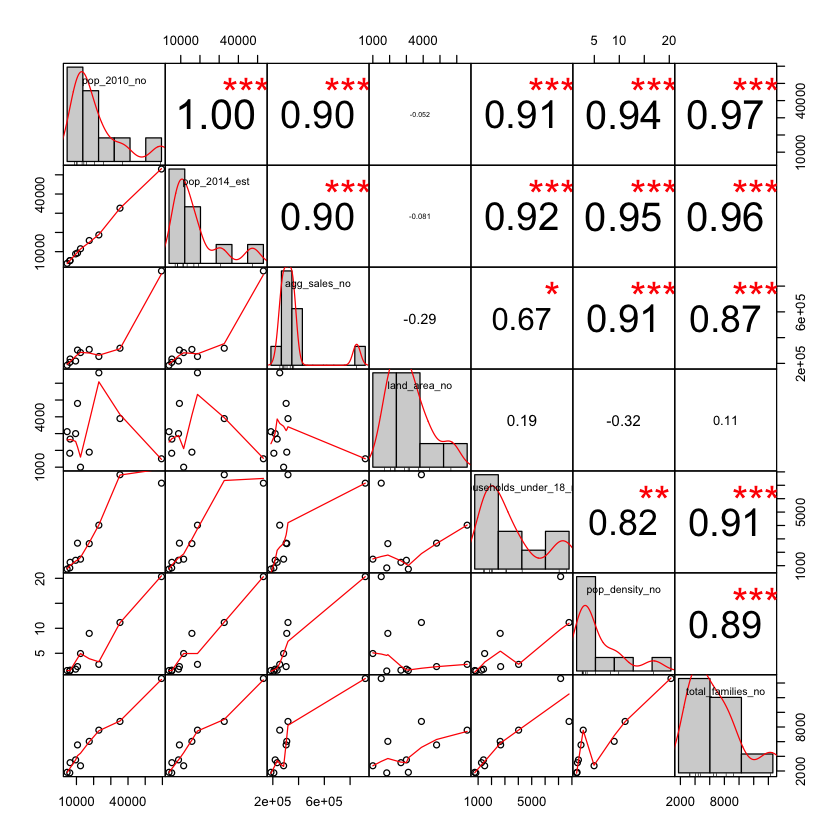

In [52]:
chart.Correlation( df.train[,-1] )

### Create linear model

In [53]:
fit.glm <- glm( agg_sales_no
              ~ land_area_no
              + total_families_no
              , family = gaussian()
              , data = df.train )

In [54]:
summary( fit.glm )


Call:
glm(formula = agg_sales_no ~ land_area_no + total_families_no, 
    family = gaussian(), data = df.train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-121261    -4453     8418    40491    75205  

Coefficients:
                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)       197330.408  56449.000   3.496   0.0101 *  
land_area_no         -48.425     14.184  -3.414   0.0112 *  
total_families_no     49.136      6.055   8.115 8.32e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for gaussian family taken to be 5188349915)

    Null deviance: 4.1194e+11  on 9  degrees of freedom
Residual deviance: 3.6318e+10  on 7  degrees of freedom
AIC: 256.51

Number of Fisher Scoring iterations: 2


### Score the remaining cities

#### Impute NA pop_2014_est value?

In [55]:
# df.comb[is.na( df.comb$pop_2014_est ),]

In [56]:
# fit.2014 <- glm( pop_2014_est
#                ~ pop_2010_no
#                + land_area_no
#                + pop_density_no
#                + total_families_no
#                , family = gaussian()
#                , data = df.comb )

In [57]:
# summary( fit.2014 )

In [58]:
# tidy( fit.2014 )

In [59]:
# df.comb$pred_2014_est <- predict( fit.2014
#        , newdata = df.comb )

So Bear River would be 439 predicted from the above model

In [60]:
df.comb[is.na( df.comb$pop_2014_est ),]$pop_2014_est <- 439

### Create predictions on new cities

In [61]:
head( df.comp )

BUSINESS.NAME,PHYSICAL.CITY.NAME,SALES.VOLUME,CASS_LastLine
Mile High Mobile Pet LLC,Cheyenne,300000,"Cheyenne, WY 82007-3528"
Pets City Inc,Cheyenne,640000,"Cheyenne, WY 82009-4851"
Petco Animal Sups Stores Inc,Cheyenne,0,"Cheyenne, WY 82009-4945"
Pet-A-Care,Cheyenne,81000,"Cheyenne, WY 82009-1009"
Muddy Paws Pet Salon,Laramie,76000,"Laramie, WY 82070-8979"
Prossers Feed and Seed L L C,Wheatland,77000,"Wheatland, WY 82201-2901"


In [62]:
df.comp <- df.comp[,c(2,3)]

In [63]:
df.comp.ag <- aggregate( df.comp$SALES.VOLUME, list( df.comp$PHYSICAL.CITY.NAME ), sum )

In [64]:
names( df.comp.ag ) <- c( 'city_nm', 'comp_sales_no')

In [65]:
df.comp <- left_join( df.comb, df.comp.ag )

Joining, by = "city_nm"
Warning message:
“Column `city_nm` joining character vector and factor, coercing into character vector”

In [66]:
df.comp.ag <- filter(df.comp.ag, comp_sales_no > 500000 )

In [67]:
df.comb <- left_join( df.comb, df.comp.ag )

Joining, by = "city_nm"
Warning message:
“Column `city_nm` joining character vector and factor, coercing into character vector”

In [68]:
df.comb <- df.comb[ !is.na( df.comb$comp_sales_no ), ]

In [69]:
df.comb$pred_sales_no <- predict( fit.glm, newdata = df.comb )

In [70]:
df.comb

,city_nm,pop_2010_no,pop_2014_est,land_area_no,households_under_18_no,pop_density_no,total_families_no,comp_sales_no,pred_sales_no
15,Cheyenne,59466,53011,1500.178,7158,20.34,14612.64,1021000,842687.5
34,Gillette,29087,19646,2748.853,4052,5.80,7189.43,1130000,417475.5
80,Rock Springs,23036,18708,6620.202,4022,2.78,7572.18,990000,248812.4
92,Torrington,6501,5776,1599.818,1034,4.39,2548.50,876991,245081.8


## Prediction and recommendation

- For a new city, with all of the criteria above, I would recommend Torrington for the new Pawdacity store.